In [157]:
import xml.etree.ElementTree as ET
from collections import namedtuple
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [158]:
plt.style.use('ggplot')

In [298]:
InputDescription = namedtuple('InputDescription', ['name', 'minimum', 'maximum'])

def load_file(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    
    inputsCount = int(root.find('inputsCount').text)
    inputDescriptions = []
    for node in root.find('inputDescriptions').findall('inputDescription'):
        inputDescriptions.append(InputDescription(
            node.find('name').text, 
            float(node.find('minimum').text), 
            float(node.find('maximum').text)))
    assert inputsCount == len(inputDescriptions)
        
    learningRate = float(root.find('learningRate').text)

    layersCount = int(root.find('layersCount').text)
    layers = []
    for node in root.find('neuronInLayersCount').findall('neuronInLayerCount'):
        layers.append(int(node.text))
    assert layersCount == len(layers)
    
    outputDescriptions = []
    for node in root.find('outputDescriptions').findall('outputDescription'):
        outputDescriptions.append(node.text)
        
    test = []
    for element in root.find('testSet').findall('testSetElement'):
        inputs = []
        for node in element.find('inputs').findall('value'):
            inputs.append(float(node.text))
        test.append(inputs)
        
    train_x = []
    train_y = []
    for element in root.find('trainSet').findall('trainSetElement'):
        inputs = []
        for node in element.find('inputs').findall('value'):
            inputs.append(float(node.text))
        outputs = []
        for node in element.find('outputs').findall('value'):
            outputs.append(float(node.text))
        train_x.append(inputs)
        train_y.append(outputs)
    
    return {
        'inputDescriptions': inputDescriptions,
        'learningRate': learningRate,
        'layers': layers,
        'outputDescriptions': outputDescriptions,
        'test': test,
        'train': (train_x, train_y)
    }

In [230]:
class Sigmoid:
    def output(self, x):
        return 1 / (1 + math.exp(-x))
    def derivative(self, x):
        output = self.output(x)
        return output * (1 - output)
    
class Relu:
    def output(self, x):
        return max(0, x)
    def derivative(self, x):
        return 0 if x <= 0 else 1

In [365]:
class Node:
    def __init__(self, activation):
        self.activation = activation
        self.inputs = []
        self.outputs = []
        self.output = None
        
    def forward(self):
        y = [edge.w * edge.nodeFrom.output for edge in self.inputs]
        self.output = self.activation.output(sum(y))

class Edge:
    def __init__(self, nodeFrom, nodeTo):
        self.nodeFrom = nodeFrom
        self.nodeFo = nodeTo
        self.w = np.random.normal()
        
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
    
    def train(self, data_x, data_y, learning_rate):
        pass
    
    def predict(self, x):        
        return [self.predict_single(item) for item in x]
    
    def predict_single(self, x):
        assert len(self.layers[0]) == len(x)
        
        for node, xi in zip(self.layers[0], x):
            node.output = xi
        
        for layer in self.layers[1:]:
            for node in layer:
                node.forward()
                
        return [node.output for node in self.layers[-1]]
        
class NeuralNetworkBuilder:
    @staticmethod
    def build(input_dim, layerDims, activation):
        layers = []
        
        layers.append([Node(activation) for _ in range(input_dim)])
        for l in layerDims:
            layers.append([Node(activation) for _ in range(l)])
        
        for i in range(1, len(layers)):
            for previous, current in itertools.product(layers[i - 1], layers[i]):
                edge = Edge(previous, current)
                previous.outputs.append(edge)
                current.inputs.append(edge)
        
        return NeuralNetwork(layers)

In [283]:
def plot_space(nn):
    step = 0.05
    v = np.arange(-10, 10 + step)
    x0, x1 = np.meshgrid(v, v)
    data_x = np.c_[x0.flatten(), x1.flatten()]
    data_y = np.array(nn.predict(data_x)).flatten()

    plt.contourf(x0, x1, data_y.reshape(x0.shape), cmap=plt.cm.bwr_r, alpha=0.5)

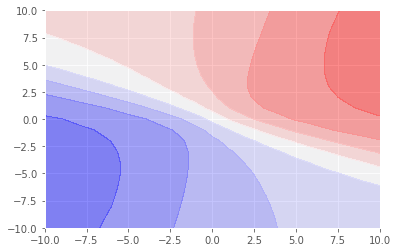

In [367]:
nn = NeuralNetworkBuilder.build(len(configuration['inputDescriptions']), configuration['layers'], Sigmoid())
plot_space(nn)

[[0], [0], [0.020043008171011945], [0]]

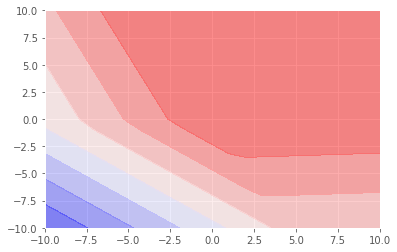

In [390]:
nn = NeuralNetworkBuilder.build(2, [2, 1], Relu())
train_x = [[0, 0], [0, 1], [1, 0], [1, 1]]
train_y = [0, 1, 1, 0]
display(nn.predict(train_x))
plot_space(nn)

In [299]:
#configuration = load_file("lekar.xml")
configuration = load_file("example2D_1.xml")
#configuration = load_file("example2D_2.xml")
#configuration = load_file("example2D_3.xml")

train_x, train_y = configuration['train']
nn.train(train_x, train_y, configuration['learningRate'])